In [1]:
using BandedMatrices, BlockBandedMatrices, BlockArrays, LinearAlgebra, SparseArrays, IntervalArithmetic, Plots, LaTeXStrings, Serialization

Calculations are done with respect to the normalised basis $\{h^m_n = \sqrt{n!/(m+n)!}H^m_n\}_{m\in \mathbb{Z}, n \in \mathbb{N}}$ and restrict ourselves to the subspace $\{h^{2m}_n\}_{m\in \mathbb{Z}, n \in \mathbb{N}}$. Recall that we aim to find $\bar{u}$ such that

$$\mathcal{L}\bar{u} \approx Q - \lambda$$

where

$$\mathcal{L} = (\alpha r - ar^3)\frac{\partial}{\partial r} +\left( b r^2 +\sqrt{a^2+b^2}r^2\cos(2\psi)\right)\frac{\partial}{\partial\psi} +\frac{\sigma^2}{2}\Delta$$

and

$$Q(r, \psi) = \alpha - 2ar^2+\sqrt{a^2+b^2}r^2\sin(2\psi)$$

For convenince, we fix $\sigma = \sqrt{2}$ and split $\mathcal{L}$ in three parts $\mathcal{L} = L + \sqrt{a^2+b^2}A +bB$

\begin{align*}
    L &= (\alpha r - a r^3)\partial_r +\Delta\\
    A &= r^2\cos(2\psi)\partial_{\psi}\\
    B &= r^2\partial_{\psi}
\end{align*}

For the action of $L$, we find that

$$r\partial_rh^m_n = - 2\sqrt{n(m+n)}h^m_{n-1} + (m+2n)h^m_n.$$

Similiary,

$$r^3\partial_rh^m_n = 2\sqrt{(n-1)n(m+n-1)(m+n)} h^m_{n-2} + (2-3m-6n)\sqrt{n(m+n)}h^m_{n-2} + (m+m^2+n(1+3m+3n))h^m_n - (m+2n)\sqrt{(n+1)(m+n+1)}h^m_{n+1}$$

and

$$\Delta h^m_n = - 4\sqrt{n(m+n)}h^m_{n-1}$$

For the action of $A$, we find that

\begin{align*}
    r^2\cos(2\psi)h^m_n = \frac{1}{2}\Big(&\sqrt{(m+n-1)(m+n)}h^{m-2}_n-2\sqrt{(n+1)(m+n)}h^{m-2}_{n+1}+\sqrt{(n+1)(n+2)}h^{m-2} _{n+2} \\
    +&\sqrt{(n-1)n}h^{m+2} _{n-2} - 2\sqrt{n(m+n+1)}h^{m+2} _{n-1} +\sqrt{(m+n+1)(m+n+2)}h^{m+2} _n\Big)
\end{align*}

For the action of $B$, we find that

$$r^2h^m_n = -\sqrt{n(m+n)}h^m_{n-1} +(1+m+2n)h^m_n - \sqrt{(n+1)(m+n+1)}h^m_{n+1}$$

Finally, we find that

$$Q = (\alpha - 2a)h^0_0 + 2ah^0_1 +\sqrt{2}\sqrt{a^2+b^2}h^2_0$$

In [2]:
a = interval(4)
α = interval(4)
b = I"21.5381"
sq = sqrt(a^2+b^2);

In [3]:
Ns = collect(500:-2:0);

In [4]:
# implements the Laplacian on each mode
function laplacian(m, N)
    n = 1:N
    c = -interval(4)*sqrt.(interval.(n.*(m .+ n)))
    return BandedMatrix(1 => c)
end

# implements the multiplication by r² on each mode
function sq_mult(m, N)
    n = 0:(N-1)
    A = -sqrt.(interval.((n .+ 1).*(m +1 .+n)))
    n = 0:N
    B = interval.((m + 1 .+ 2 .*n))
    n = 1:N
    C = -sqrt.(interval.(n.*(n .+ m)))
    return BandedMatrix(-1 => A, 0 => B, 1 => C)
end

# shifts down basis functions in one mode to twice-below mode and multiply by r²
function shift_down(m, N)
    n = 0:(N-2)
    A = sqrt.(interval.((n .+ 1).* (n .+ 2)))
    n = 0:(N-1)
    B = -interval(2)*sqrt.(interval.((n .+ m).* (n .+ 1)))
    n = 0:N
    C = sqrt.(interval.((n .+ m).* (n .+ m .- 1)))
    return BandedMatrix(-2 => A, -1 => B, 0 => C) #/interval(2)
end

# shifts down basis functions in one mode to twice-above mode and multiply by r²
function shift_up(m, N)
    n = 0:N
    A = sqrt.(interval.((m + 1 .+ n).*(m + 2 .+ n)))
    n = 1:N
    B = -interval(2)*sqrt.(interval.(n.*(m + 1 .+ n)))
    n = 2:N
    C = sqrt.(interval.(n.*(n .- 1)))
    return BandedMatrix(0 => A, 1 => B, 2 => C) #/interval(2)
end

# implements the operator r³∂ᵣ on each mode

function cubic_drift(m, N)
    n = 0:(N-1)
    A = - interval.(m .+2 .*n ) .*sqrt.(interval.((n.+1).*(m+1 .+n)))
    n = 0:N
    B = interval.(m + m^2 .+ 2 .*n.*(1 +3*m .+ 3*n))
    n = 1:N
    C = interval.(2 - 3*m .- 6 .*n).*sqrt.(interval.(n.*(n .+ m)))
    n = 2:N
    D = interval(2)*sqrt.(interval.(n .*(n .- 1).*(m - 1 .+n).*(m.+n)))
    return BandedMatrix(-1 => A, 0 => B, 1 => C , 2=> D)
end

# implements the operator r∂ᵣ on each mode

function linear_drift(m, N)
    n = 0:N
    B = interval.(m .+ 2 .*n)
    n = 1:N
    C = -interval(2).*sqrt.(interval.(n.*(n .+ m)))
    return BandedMatrix(0 => B, 1 => C)
end

linear_drift (generic function with 1 method)

In [5]:
# implements L = (αr - ar³)∂ᵣ+ Δ
function build_L(Ns)
    NS = vcat(Ns[1]+1, Ns);
    cols = reverse(sort(vcat(Ns[1]+3, Ns.+1, Ns.+1)))
    rows = reverse(sort(vcat(NS[1]+3, NS.+1, NS.+1)))
    # cols = rows = reverse(sort(vcat(Ns.+1, Ns.+1)))
    L = BandedBlockBandedMatrix(Zeros(Interval{Float64}, sum(rows),sum(cols)), rows,cols, (0,0), (3, 3))
    L[Block(1,1)] = (α*linear_drift(0, cols[1]+4) - a*cubic_drift(0, cols[1]+4) + laplacian(0, cols[1]+4))[1:rows[1],1:cols[1]]
    for m=1:length(Ns)
        L[Block(2*m,2*m)] = L[Block(2*m+1,2*m+1)] = (α*linear_drift(2*m, cols[2*m]+4) - a*cubic_drift(2*m, cols[2*m]+4) + laplacian(2*m, cols[2*m]+4))[1:rows[2*m],1:cols[2*m]]
    end
    return L
end

# implements B = r²∂ψ
function build_B(Ns)
    NS = vcat(Ns[1]+1, Ns);
    cols = reverse(sort(vcat(Ns[1]+3, Ns.+1, Ns.+1)))
    rows = reverse(sort(vcat(NS[1]+3, NS.+1, NS.+1)))
    # cols = rows = reverse(sort(vcat(Ns.+1, Ns.+1)))
    B = BandedBlockBandedMatrix(Zeros(Interval{Float64}, sum(rows),sum(cols)), rows,cols, (1,1), (3, 3))
    for m=1:length(Ns)
        B[Block(2*m,2*m+1)] = interval(2*m)*(sq_mult(2*m, cols[2*m]+4))[1:rows[2*m],1:cols[2*m]]
        B[Block(2*m+1,2*m)] = -interval(2*m)*(sq_mult(2*m, cols[2*m]+4))[1:rows[2*m],1:cols[2*m]]
    end
    return B
end

# implements A = r²cos(2ψ)∂ψ
function build_A(Ns)
    NS = vcat(Ns[1]+1, Ns);
    cols = reverse(sort(vcat(Ns[1]+3, Ns.+1, Ns.+1)))
    rows = reverse(sort(vcat(NS[1]+3, NS.+1, NS.+1)))
    # cols = rows = reverse(sort(vcat(Ns.+1, Ns.+1)))
    A = BandedBlockBandedMatrix(Zeros(Interval{Float64}, sum(rows),sum(cols)), rows,cols, (3,3), (3, 3))
    A[Block(1,3)] = (shift_down(2, cols[1]+4))[1:rows[1],1:cols[2]]
    for m=1:length(NS)
        if m<length(Ns)
            A[Block(2*m,2*m+3)] = interval( m+1)*(shift_down(2*m+2, cols[2*m]+4))[1:rows[2*m],1:cols[2*m+2]]
            A[Block(2*m+1,2*m+2)] = -interval(m+1)*(shift_down(2*m+2, cols[2*m]+4))[1:rows[2*m],1:cols[2*m+2]]
        end
        if m>1
            A[Block(2*m,2*m-1)] = interval(m-1)*(shift_up(2*m-2,cols[2*m-2]+4))[1:rows[2*m],1:cols[2*m-2]]
            A[Block(2*m+1,2*m-2)] = -interval(m-1)*(shift_up(2*m-2, cols[2*m-2]+4))[1:rows[2*m],1:cols[2*m-2]]
        end
    end
    return A
end

build_A (generic function with 1 method)

In [6]:
L = build_L(Ns)
A = build_A(Ns)
B = build_B(Ns);

In [7]:
𝔏 =  (mid(sq)*mid.(sparse(A))+mid(b)*mid.(sparse(B)) + mid.(sparse(L)))[2:end,:];

In [8]:
NS = vcat(Ns[1]+1, Ns)
cols = reverse(sort(vcat(Ns[1]+3, Ns.+1, Ns.+1)))
rows = reverse(sort(vcat(NS[1]+3, NS.+1, NS.+1)))
Q = BlockVector(zeros(Interval{Float64}, sum(rows)), rows)
Q[Block(1)[1]] = α - interval(2)*a
Q[Block(1)[2]] = interval(2)*a
Q[Block(3)[1]] = sq*sqrt(interval(2))

[30.9803, 30.9804]_com

In [9]:
ū = collect(interval.(𝔏 \ collect(mid.(Q)[2:end])));

We choose

$$W(r,\psi) = e^{ar^4/8} = e^{r^4/2}$$

Thus, we find that

$$\mu(W) = \int_0^{2\pi}\int_0^{\infty}e^{r^4/2}\mu(\mathrm{d}r) = \frac{\displaystyle\int_0^{\infty}e^{-r^4/2+2r^2}r\mathrm{d} r}{\displaystyle\int_0^{\infty}e^{-r^4+2r^2}r\mathrm{d} r} = \frac{\sqrt{2}e(\mathrm{erf}(\sqrt{2})+1)}{\mathrm{erf}(1)+1}$$

In [11]:
suppsi = deserialize("suppsi");

In [13]:
ϵ = (b*B*ū+sq*A*ū+L*ū)- Q;

λ̄ = -ϵ[1]
ϵ[1] = interval(0)
μW = deserialize("muW")
δ = sum(abs.(ϵ).*suppsi)*μW
λ = λ̄ +interval(-1,1)*δ

[0.000348268, 0.0003575]_com

### Plotting ###

In [80]:
using Combinatorics
setprecision(512)
ū = BlockVector(ū, cols)
rloc = big.(collect(0:200))/100;
x = rloc.^2
cuᵣ = zeros((length(Ns)+1, 201))
suᵣ = zeros((length(Ns), 201))

Lprev = ones(BigFloat, length(x))
L = 1.0 .- x

for n=0:big(Ns[1]+2)
    cuᵣ[1,:] += mid(ū[Block(1)[n+1]])*Lprev
    L , Lprev = ((2*n + 1 .-x).*L - n*Lprev)/(n+1), copy(L)
    # println(n)
end

for m=1:length(Ns)
    Lprev = ones(BigFloat, length(x))
    L = 2*m + 1.0 .- x
    for n=0:big(Ns[m])
        Z = sqrt(factorial(2*m+n)÷factorial(n))
        cuᵣ[m+1,:] += x.^m .*mid(ū[Block(2*m)[n+1]]).*Lprev/Z
        suᵣ[m,:] += x.^m .*mid(ū[Block(2*m+1)[n+1]]).*Lprev/Z
        L , Lprev = ((2*(n+m) + 1 .-x).*L - (n+2*m)*Lprev)/(n+1), copy(L)
    end
end

In [81]:
ϑ = big.(collect(0:100))/100*2*big(π)
c = cos.(ϑ.*collect(0:2:2*length(Ns))');
s = sin.(ϑ.*collect(2:2:2*length(Ns))');

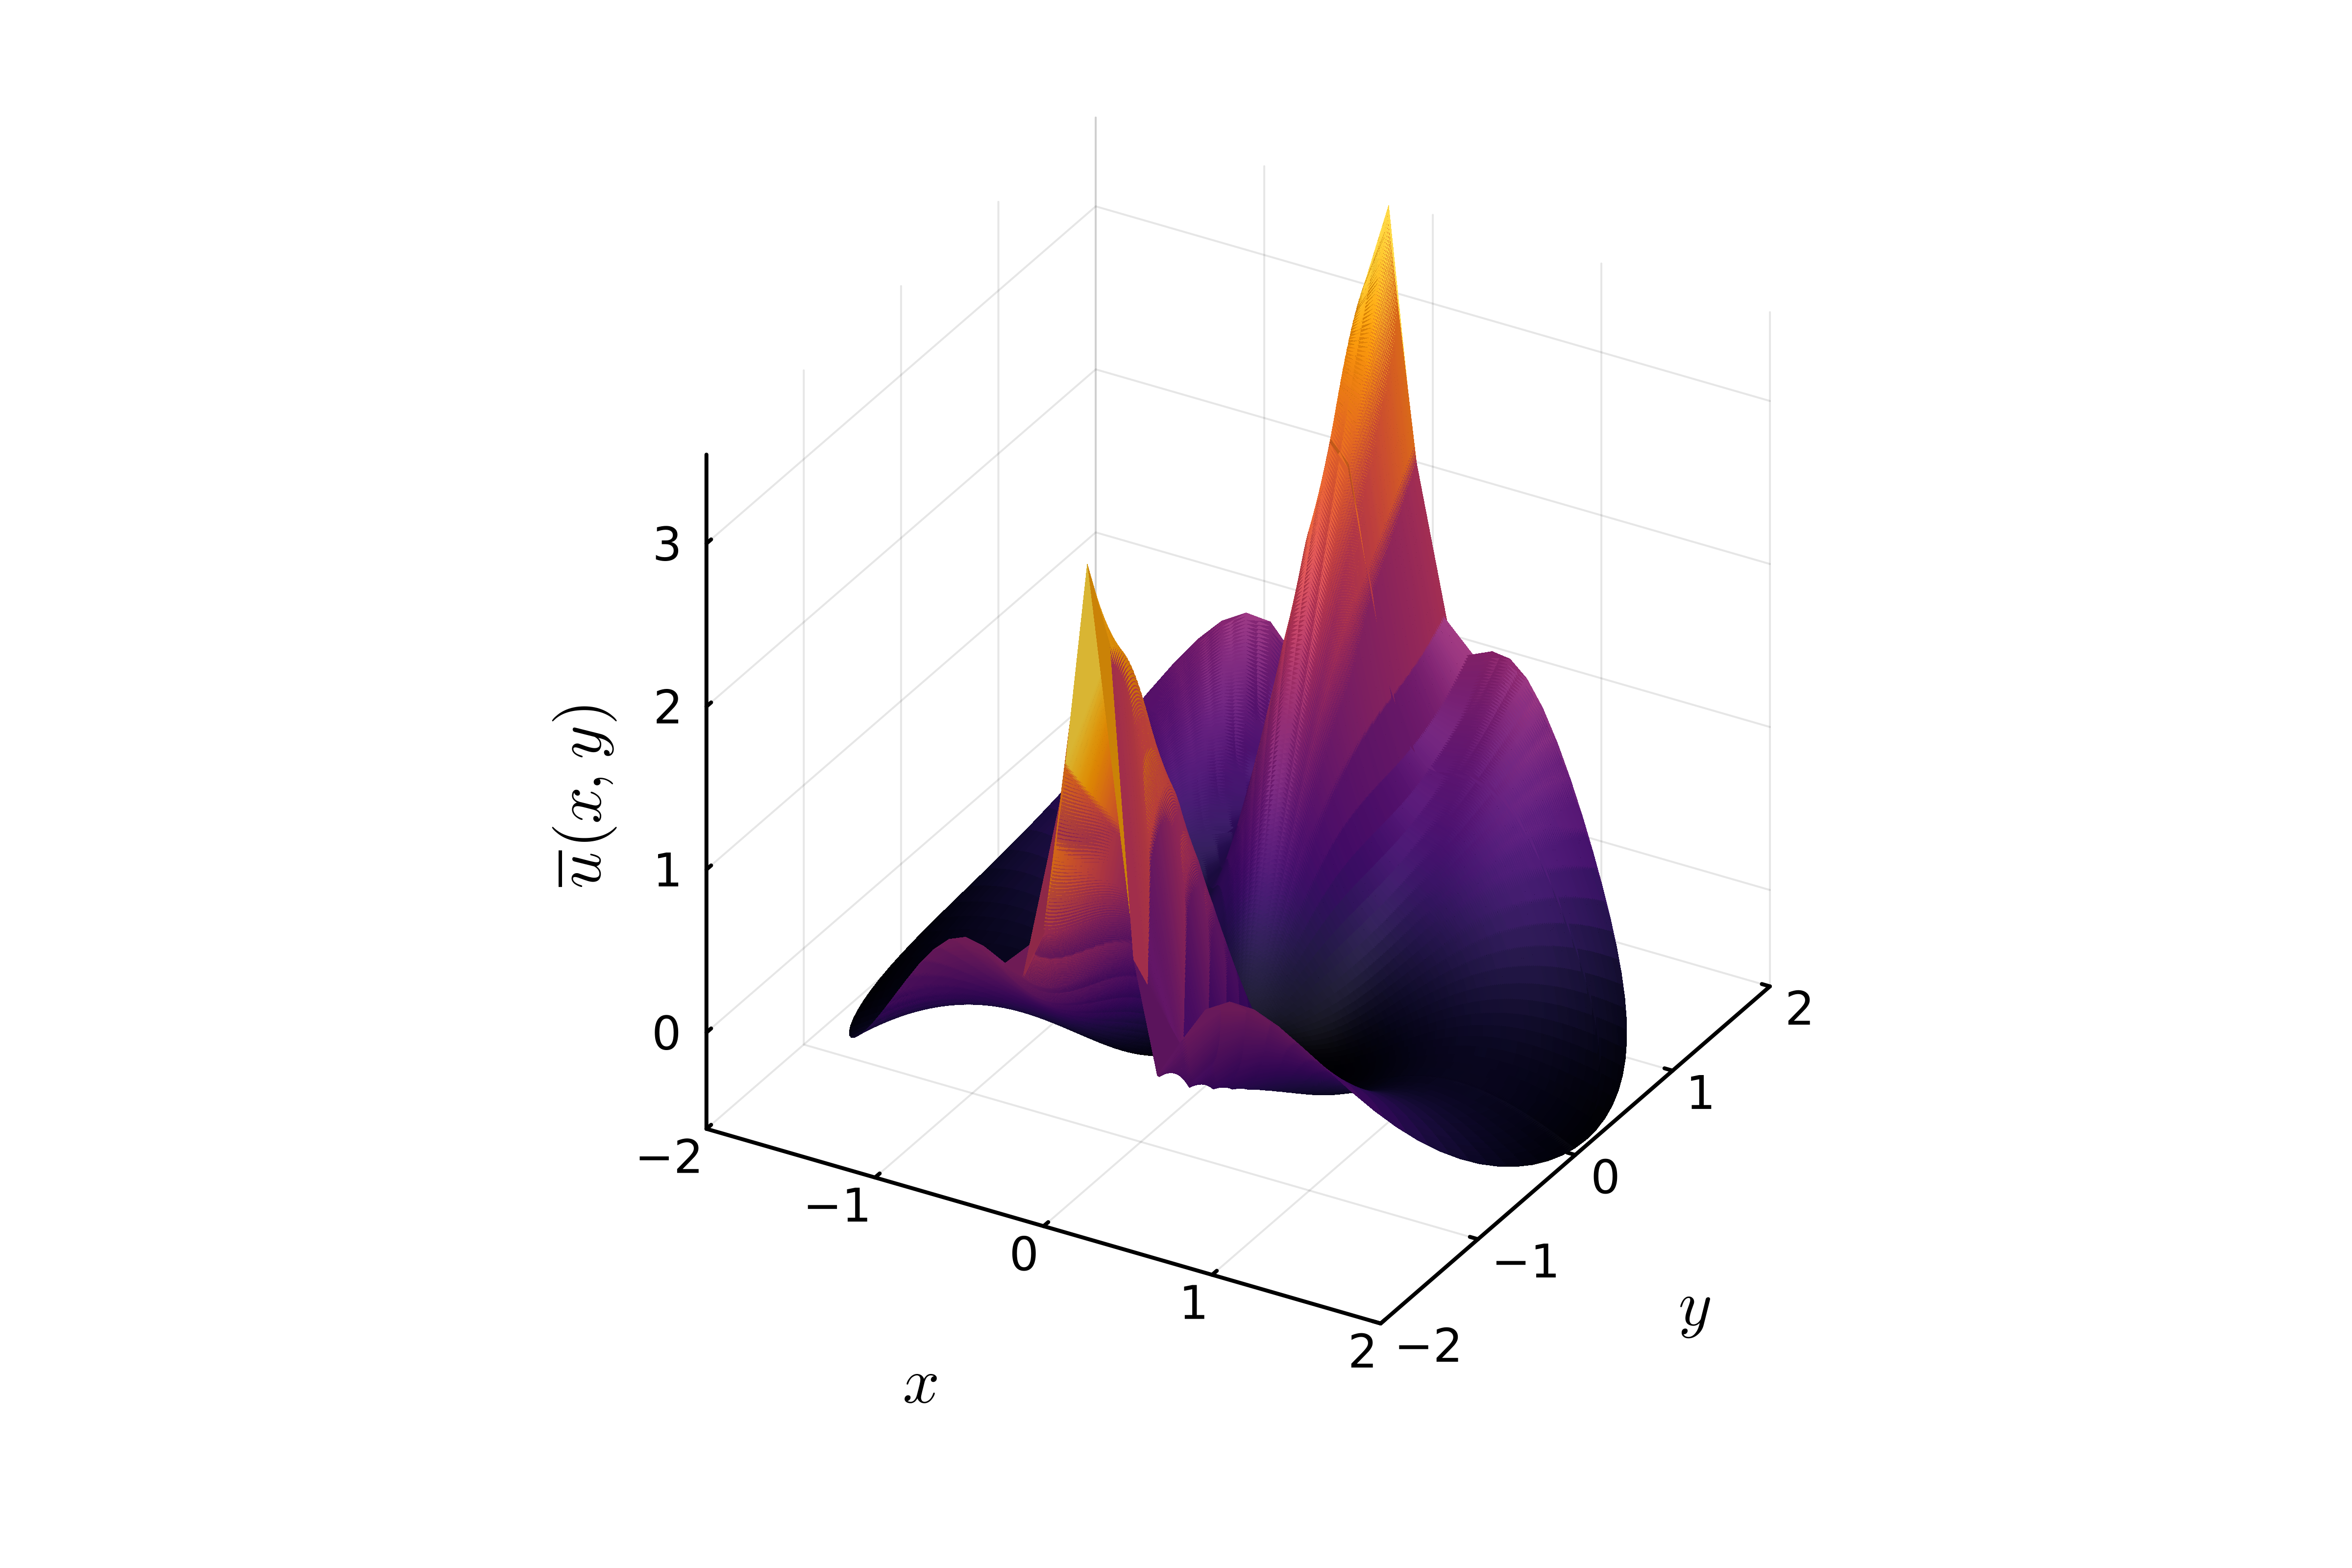

In [82]:
surface(rloc.*cos.(ϑ'),rloc.*sin.(ϑ'), (c*cuᵣ)'+(s*suᵣ)', xlabel = L"$x$", ylabel = L"$y$", zlabel = L"$\overline{u}\,(x, y)$", colorbar = false, dpi = 800)

In [83]:
png("Hopf_ubar")

"Hopf_ubar.png"